# Biomass Prediction Inference Notebook

This notebook processes satellite imagery and predicts above-ground biomass using the trained StableResNet model.

Author: najahpokkiri  
Date: 2025-05-17  

## Overview

1. Load satellite imagery
2. Apply the same feature engineering pipeline used in training
3. Generate predictions using the trained model
4. Visualize and export results

This notebook is optimized for memory efficiency when processing large images.

## 1. Import Libraries and Setup

In [1]:
# Essential imports
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Specialized libraries
import torch
import rasterio
from rasterio.windows import Window
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
import logging

# Optional imports for texture features
try:
    from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
    from skimage.filters import sobel
    skimage_available = True
except ImportError:
    print("Warning: scikit-image not available. Texture features will be disabled.")
    skimage_available = False

# Suppress warnings
warnings.filterwarnings("ignore")

# Configure logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print(f"Notebook initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

Notebook initialized at: 2025-05-17 18:02:24
PyTorch version: 2.7.0+cu126
NumPy version: 2.2.5


## 2. Configuration

In [ ]:
class Config:
    """Configuration class with all parameters for the inference pipeline"""
    def __init__(self):
        # File paths
        self.model_dir = "/teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706"
        self.input_image = "/teamspace/studios/this_studio/files/s1_s2_l8_palsar_ch_dem_goa_2020_rect.tif"
        self.output_dir = f"biomass_predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Processing parameters
        self.chunk_size = 256  # Size of chunks for processing large images
        self.overlap = 64     # Overlap between chunks to avoid edge artifacts
        
        # Feature engineering options (should match training)
        self.use_advanced_indices = True
        self.use_texture_features = True and skimage_available
        self.use_spatial_features = True
        self.use_pca_features = True
        self.pca_components = 25
        
        # Transformation parameters
        self.use_log_transform = True
        self.epsilon = 1.0
        
        # Device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def display(self):
        """Display configuration settings"""
        print("\nConfiguration:")
        for key, value in self.__dict__.items():
            print(f"  {key}: {value}")

# Create configuration
config = Config()

# Create output directory
os.makedirs(config.output_dir, exist_ok=True)
print(f"Output directory: {config.output_dir}")

# Display configuration
config.display()

Output directory: biomass_predictions_20250517_180224

Configuration:
  model_dir: /teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706
  input_image: /teamspace/studios/this_studio/files/s1_s2_l8_palsar_ch_dem_goa_2020_rect.tif
  output_dir: biomass_predictions_20250517_180224
  chunk_size: 256
  overlap: 64
  use_advanced_indices: True
  use_texture_features: True
  use_spatial_features: True
  use_pca_features: True
  pca_components: 25
  use_log_transform: True
  epsilon: 1.0
  device: cuda


## 3. Define Model Architecture

In [3]:
class StableResNet(torch.nn.Module):
    """Numerically stable ResNet for biomass regression"""
    def __init__(self, n_features, dropout=0.2):
        super().__init__()
        
        self.input_proj = torch.nn.Sequential(
            torch.nn.Linear(n_features, 256),
            torch.nn.LayerNorm(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout)
        )
        
        self.layer1 = self._make_simple_resblock(256, 256)
        self.layer2 = self._make_simple_resblock(256, 128)
        self.layer3 = self._make_simple_resblock(128, 64)
        
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
    
    def _make_simple_resblock(self, in_dim, out_dim):
        return torch.nn.Sequential(
            torch.nn.Linear(in_dim, out_dim),
            torch.nn.BatchNorm1d(out_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(out_dim, out_dim),
            torch.nn.BatchNorm1d(out_dim),
            torch.nn.ReLU()
        ) if in_dim == out_dim else torch.nn.Sequential(
            torch.nn.Linear(in_dim, out_dim),
            torch.nn.BatchNorm1d(out_dim),
            torch.nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.input_proj(x)
        
        identity = x
        out = self.layer1(x)
        x = out + identity
        
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.regressor(x)
        return x.squeeze()

## 4. Load Model and Metadata

In [4]:
def load_model_and_metadata(config):
    """Load model, scaler, and feature names"""
    try:
        # Load feature names
        feature_path = os.path.join(config.model_dir, "feature_names.txt")
        if os.path.exists(feature_path):
            with open(feature_path, 'r') as f:
                feature_names = [line.strip() for line in f if line.strip()]
            print(f"Loaded {len(feature_names)} feature names from {feature_path}")
        else:
            print(f"Feature names file not found at {feature_path}")
            feature_names = []
        
        n_features = len(feature_names) if feature_names else 99
        
        # Load model
        model_path = os.path.join(config.model_dir, "model.pt")
        if not os.path.exists(model_path):
            print(f"Model file not found at {model_path}")
            return None, None, feature_names
        
        model = StableResNet(n_features=n_features)
        model.load_state_dict(torch.load(model_path, map_location=config.device))
        model.to(config.device)
        model.eval()
        print(f"Model loaded successfully from {model_path}")
        
        # Try to load model package (for scaler)
        package = None
        package_path = os.path.join(config.model_dir, "model_package.pkl")
        if os.path.exists(package_path):
            try:
                package = joblib.load(package_path)
                print(f"Model package loaded from {package_path}")
                
                # Update config from package if available
                if 'use_log_transform' in package:
                    config.use_log_transform = package['use_log_transform']
                if 'epsilon' in package:
                    config.epsilon = package['epsilon']
                
                print(f"Updated configuration: log_transform={config.use_log_transform}, epsilon={config.epsilon}")
            except Exception as e:
                print(f"Error loading model package: {e}")
        else:
            print(f"Model package not found at {package_path}")
        
        return model, package, feature_names
    
    except Exception as e:
        print(f"Error loading model and metadata: {e}")
        import traceback
        traceback.print_exc()
        return None, None, []

# Load model and metadata
model, package, feature_names = load_model_and_metadata(config)

Loaded 99 feature names from /teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706/feature_names.txt
Model loaded successfully from /teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706/model.pt
Model package loaded from /teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706/model_package.pkl
Updated configuration: log_transform=True, epsilon=1.0


## 5. Feature Engineering Functions

In [5]:
def safe_divide(a, b, fill_value=0.0):
    """Safe division that handles zeros in the denominator"""
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    
    # Handle NaN/Inf in inputs
    a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)
    b = np.nan_to_num(b, nan=1e-10, posinf=1e10, neginf=-1e10)
    
    if a.ndim == 0 and b.ndim > 0:
        a = np.full_like(b, a)
    elif b.ndim == 0 and a.ndim > 0:
        b = np.full_like(a, b)
    elif a.ndim == 0 and b.ndim == 0:
        if abs(b) < 1e-10:
            return fill_value
        else:
            return float(a / b)
    
    mask = np.abs(b) < 1e-10
    result = np.full_like(a, fill_value, dtype=np.float32)
    if np.any(~mask):
        result[~mask] = a[~mask] / b[~mask]
    
    result = np.nan_to_num(result, nan=fill_value, posinf=fill_value, neginf=fill_value)
    return result


def calculate_spectral_indices(satellite_data):
    """Calculate spectral indices from satellite bands"""
    indices = {}
    n_bands = satellite_data.shape[0]
    
    # Enhanced band mapping with error checking
    def safe_get_band(idx):
        return satellite_data[idx] if idx < n_bands else None
    
    # Sentinel-2 bands (assuming standard band order)
    # B2(blue), B3(green), B4(red), B8(nir), B11(swir1), B12(swir2)
    try:
        blue = safe_get_band(1)  # Adjust indices based on your data
        green = safe_get_band(2)
        red = safe_get_band(3)
        nir = safe_get_band(7)
        swir1 = safe_get_band(9)
        swir2 = safe_get_band(10)
        
        if all(b is not None for b in [red, nir]):
            # NDVI (Normalized Difference Vegetation Index)
            indices['NDVI'] = safe_divide(nir - red, nir + red)
            
            if blue is not None and green is not None:
                # EVI (Enhanced Vegetation Index)
                indices['EVI'] = 2.5 * safe_divide(nir - red, nir + 6*red - 7.5*blue + 1)
                
                # SAVI (Soil Adjusted Vegetation Index)
                indices['SAVI'] = 1.5 * safe_divide(nir - red, nir + red + 0.5)
                
                # MSAVI2 (Modified Soil Adjusted Vegetation Index)
                indices['MSAVI2'] = 0.5 * (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red)))
                
                # NDWI (Normalized Difference Water Index)
                indices['NDWI'] = safe_divide(green - nir, green + nir)
        
        if swir1 is not None and nir is not None:
            # NDMI (Normalized Difference Moisture Index)
            indices['NDMI'] = safe_divide(nir - swir1, nir + swir1)
        
        if swir2 is not None and nir is not None:
            # NBR (Normalized Burn Ratio)
            indices['NBR'] = safe_divide(nir - swir2, nir + swir2)
            
    except Exception as e:
        print(f"Warning: Error calculating spectral indices: {e}")
    
    # Clean up None values and NaNs
    indices = {k: np.nan_to_num(v, nan=0.0) for k, v in indices.items() if v is not None}
    return indices


def extract_texture_features(satellite_data, config):
    """Extract texture features from satellite data"""
    if not config.use_texture_features or not skimage_available:
        return {}
    
    texture_features = {}
    height, width = satellite_data.shape[1], satellite_data.shape[2]
    
    # Select representative bands for texture analysis (e.g., NIR bands)
    key_bands = [7]  # NIR band
    
    for band_idx in key_bands:
        if band_idx >= satellite_data.shape[0]:
            continue
            
        try:
            band = satellite_data[band_idx].copy()
            
            # Normalize to 0-255 for texture analysis
            band_min, band_max = np.nanpercentile(band[~np.isnan(band)], [1, 99])
            band_norm = np.clip((band - band_min) / (band_max - band_min + 1e-8), 0, 1)
            band_norm = (band_norm * 255).astype(np.uint8)
            
            # Replace NaN with median
            band_norm = np.nan_to_num(band_norm, nan=np.nanmedian(band_norm))
            
            # Edge detection using Sobel
            sobel_response = sobel(band_norm.astype(float))
            texture_features[f'Sobel_B{band_idx}'] = sobel_response
            
            # Local Binary Pattern
            try:
                lbp = local_binary_pattern(band_norm, 8, 1, method='uniform')
                texture_features[f'LBP_B{band_idx}'] = lbp
            except Exception as e:
                print(f"Warning: Error calculating LBP for band {band_idx}: {e}")
                
            # GLCM properties - simplified approach for efficiency
            sample_size = min(128, band_norm.shape[0], band_norm.shape[1])
            center_y, center_x = band_norm.shape[0]//2, band_norm.shape[1]//2
            offset = sample_size // 2
            patch = band_norm[center_y-offset:center_y+offset, center_x-offset:center_x+offset]
            
            if patch.size > 0:
                try:
                    glcm = graycomatrix(patch, [1], [0], levels=256, symmetric=True, normed=True)
                    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy']:
                        value = float(graycoprops(glcm, prop)[0, 0])
                        texture_features[f'GLCM_{prop}_B{band_idx}'] = np.full((height, width), value, dtype=np.float32)
                except Exception as e:
                    print(f"Warning: Error calculating GLCM for band {band_idx}: {e}")
                    
        except Exception as e:
            print(f"Warning: Error processing band {band_idx} for texture: {e}")
    
    return texture_features


def calculate_spatial_features(satellite_data, indices, config):
    """Calculate spatial context features like gradients"""
    if not config.use_spatial_features:
        return {}
    
    spatial_features = {}
    height, width = satellite_data.shape[1], satellite_data.shape[2]
    
    # Key bands for spatial analysis
    key_bands = [7]  # NIR band
    
    for band_idx in key_bands:
        if band_idx < satellite_data.shape[0]:
            try:
                band = satellite_data[band_idx].copy()
                band = np.nan_to_num(band, nan=0.0)
                
                # Calculate gradients
                grad_y, grad_x = np.gradient(band)
                grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
                spatial_features[f'Gradient_B{band_idx}'] = grad_magnitude
                
            except Exception as e:
                print(f"Warning: Error calculating spatial features for band {band_idx}: {e}")
    
    # Gradient features for NDVI if available
    if 'NDVI' in indices:
        try:
            ndvi_clean = np.nan_to_num(indices['NDVI'], nan=0.0)
            
            # Calculate gradients
            grad_y, grad_x = np.gradient(ndvi_clean)
            grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
            spatial_features['NDVI_gradient'] = grad_magnitude
            
        except Exception as e:
            print(f"Warning: Error calculating gradient for NDVI: {e}")
    
    return spatial_features


def calculate_pca_features(satellite_data, config):
    """Calculate PCA features from satellite bands"""
    if not config.use_pca_features:
        return {}
    
    # Reshape for PCA (pixels x bands)
    height, width = satellite_data.shape[1], satellite_data.shape[2]
    bands_reshaped = satellite_data.reshape(satellite_data.shape[0], -1).T
    
    # Handle NaN values
    valid_mask = ~np.any(np.isnan(bands_reshaped), axis=1)
    bands_clean = bands_reshaped[valid_mask]
    
    if len(bands_clean) == 0:
        print("Warning: No valid data for PCA")
        return {}
    
    try:
        # Standardize and apply PCA
        scaler = StandardScaler()
        bands_scaled = scaler.fit_transform(bands_clean)
        
        pca = PCA(n_components=min(config.pca_components, bands_scaled.shape[1]))
        pca_features = pca.fit_transform(bands_scaled)
        
        # Create full PCA array
        pca_full = np.zeros((height * width, pca_features.shape[1]))
        pca_full[valid_mask] = pca_features
        pca_full = pca_full.reshape(height, width, pca_features.shape[1])
        
        # Convert to dictionary format
        pca_dict = {}
        for i in range(pca_full.shape[2]):
            pca_dict[f'PCA_{i+1:02d}'] = pca_full[:, :, i]
        
        explained_variance = pca.explained_variance_ratio_.sum()
        print(f"PCA explained variance: {explained_variance:.3f}")
        
        return pca_dict
        
    except Exception as e:
        print(f"Warning: Error calculating PCA: {e}")
        return {}

## 6. Image Loading Function

In [6]:
def load_image_metadata(config):
    """Load image metadata without loading the entire image"""
    try:
        with rasterio.open(config.input_image) as src:
            metadata = {
                'width': src.width,
                'height': src.height,
                'count': src.count,
                'dtype': src.dtypes[0],
                'crs': src.crs,
                'transform': src.transform,
                'bounds': src.bounds,
                'nodata': src.nodata
            }
        print(f"Image size: {metadata['width']}x{metadata['height']}, {metadata['count']} bands")
        return metadata
    except Exception as e:
        print(f"Error loading image metadata: {e}")
        return None

# Load image metadata
image_metadata = load_image_metadata(config)
if image_metadata is None:
    print("Could not load image metadata. Please check the input file path.")

Image size: 2168x2721, 59 bands


## 7. Chunked Processing Functions

In [7]:
def get_chunks(width, height, chunk_size, overlap):
    """Generate processing chunks with overlap"""
    chunks = []
    for y in range(0, height, chunk_size - overlap):
        for x in range(0, width, chunk_size - overlap):
            # Adjust chunk size at edges
            w = min(chunk_size, width - x)
            h = min(chunk_size, height - y)
            chunks.append(Window(x, y, w, h))
    return chunks

def process_chunk(chunk, window, feature_names, model, package, config):
    """Process a single chunk of the image"""
    try:
        # Extract dimensions
        n_bands, chunk_height, chunk_width = chunk.shape
        
        # Create mask for valid pixels
        valid_mask = np.all(np.isfinite(chunk), axis=0)
        if np.sum(valid_mask) == 0:
            # Skip if no valid pixels
            return np.zeros((chunk_height, chunk_width), dtype=np.float32), window
        
        # 1. Generate spectral indices
        indices = calculate_spectral_indices(chunk) if config.use_advanced_indices else {}
        
        # 2. Extract texture features
        texture_features = extract_texture_features(chunk, config) if config.use_texture_features else {}
        
        # 3. Calculate spatial features
        spatial_features = calculate_spatial_features(chunk, indices, config) if config.use_spatial_features else {}
        
        # 4. Calculate PCA features
        pca_features = calculate_pca_features(chunk, config) if config.use_pca_features else {}
        
        # 5. Compile all features
        all_features = {}
        
        # Original bands
        for i in range(n_bands):
            all_features[f'Band_{i+1:02d}'] = chunk[i]
        
        # Add other feature types
        all_features.update(indices)
        all_features.update(texture_features)
        all_features.update(spatial_features)
        all_features.update(pca_features)
        
        # 6. Extract features in correct order
        y_indices, x_indices = np.where(valid_mask)
        feature_matrix = np.zeros((len(y_indices), len(feature_names)), dtype=np.float32)
        
        for i, feature_name in enumerate(feature_names):
            if feature_name in all_features:
                feature_data = all_features[feature_name]
                feature_values = feature_data[y_indices, x_indices] if feature_data.ndim == 2 else feature_data
                feature_values = np.nan_to_num(feature_values, nan=0.0)
                feature_matrix[:, i] = feature_values
            else:
                # If feature is missing, use zeros
                feature_matrix[:, i] = 0.0
        
        # 7. Apply scaling if available
        if package is not None and 'scaler' in package:
            try:
                feature_matrix = package['scaler'].transform(feature_matrix)
            except Exception as e:
                print(f"Warning: Error applying scaler: {e}")
        
        # 8. Make predictions
        predictions = np.zeros((chunk_height, chunk_width), dtype=np.float32)
        
        with torch.no_grad():
            # Process in batches to avoid memory issues
            batch_size = 10000
            for i in range(0, len(y_indices), batch_size):
                end_idx = min(i + batch_size, len(y_indices))
                batch = feature_matrix[i:end_idx]
                batch_tensor = torch.tensor(batch, dtype=torch.float32).to(config.device)
                
                # Get predictions but handle scalar case
                raw_preds = model(batch_tensor)
                
                # Handle scalar case properly
                if len(raw_preds.shape) == 0:  # It's a scalar
                    batch_preds = np.array([raw_preds.cpu().item()])
                else:
                    batch_preds = raw_preds.cpu().numpy()
                
                # Convert from log scale if needed
                if config.use_log_transform:
                    batch_preds = np.exp(batch_preds) - config.epsilon
                    batch_preds = np.maximum(batch_preds, 0)  # Ensure non-negative
                
                # Map predictions back to the correct pixels
                for j in range(end_idx - i):
                    y_idx = y_indices[i + j]
                    x_idx = x_indices[i + j]
                    predictions[y_idx, x_idx] = batch_preds[j]
        
        return predictions, window
        
    except Exception as e:
        print(f"Error processing chunk {window}: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros((chunk_height, chunk_width), dtype=np.float32), window

def read_chunk(src, window, padding=32):
    """Read a chunk of the image with padding"""
    try:
        # Calculate padded window coordinates
        padded_window = Window(
            max(0, window.col_off - padding),
            max(0, window.row_off - padding),
            min(window.width + 2*padding, src.width - window.col_off),
            min(window.height + 2*padding, src.height - window.row_off)
        )
        
        # Read padded chunk
        padded_chunk = src.read(window=padded_window)
        
        # Track padding offsets for later
        x_pad_left = window.col_off - padded_window.col_off
        y_pad_top = window.row_off - padded_window.row_off
        
        return padded_chunk, padded_window, (x_pad_left, y_pad_top)
    except Exception as e:
        print(f"Error reading chunk {window}: {e}")
        return None, window, (0, 0)

## 8. Main Prediction Function

In [8]:
def predict_biomass(config, model, package, feature_names):
    """Process the entire image and make predictions"""
    # Check if model is loaded
    if model is None:
        print("No model loaded. Cannot make predictions.")
        return None
    
    if not feature_names:
        print("No feature names provided.")
        return None
    
    # Check if image metadata is loaded
    if image_metadata is None:
        print("Image metadata not loaded. Cannot process image.")
        return None
    
    width, height = image_metadata['width'], image_metadata['height']
    n_bands = image_metadata['count']
    print(f"Processing image: {width}x{height} with {n_bands} bands")
    
    # Define padding size (typically 32-48 pixels works well)
    padding = 48
    
    # Get processing chunks
    chunks = get_chunks(width, height, config.chunk_size, config.overlap)
    print(f"Image will be processed in {len(chunks)} chunks")
    
    # Initialize output array
    prediction_array = np.zeros((height, width), dtype=np.float32)
    weight_array = np.zeros((height, width), dtype=np.float32)  # For weighted averaging of overlapping regions
    
    # Process image in chunks
    with rasterio.open(config.input_image) as src:
        start_time = time.time()
        
        for i, window in enumerate(chunks):
            chunk_start = time.time()
            
            # Read chunk with padding
            padded_window = Window(
                max(0, window.col_off - padding),
                max(0, window.row_off - padding),
                min(window.width + 2*padding, width - window.col_off),
                min(window.height + 2*padding, height - window.row_off)
            )
            
            # Read padded chunk - fixed the unpacking issue
            padded_result = read_chunk(src, padded_window)
            if padded_result is None or padded_result[0] is None:
                continue
                
            padded_chunk = padded_result[0]  # Extract chunk from result tuple
            
            # Calculate original chunk position within padded chunk
            x_offset = window.col_off - padded_window.col_off
            y_offset = window.row_off - padded_window.row_off
            
            # Process padded chunk
            print(f"\rProcessing chunk {i+1}/{len(chunks)} - Shape: {padded_chunk.shape}", end="")
            
            # Process chunk and handle return values properly
            process_result = process_chunk(padded_chunk, padded_window, feature_names, model, package, config)
            padded_pred = process_result[0]  # Extract predictions from result tuple
            
            # Extract only the central portion corresponding to original window
            orig_height, orig_width = window.height, window.width
            chunk_pred = padded_pred[y_offset:y_offset+orig_height, x_offset:x_offset+orig_width]
            
            # Create a weight mask for this chunk (higher in center, lower at edges)
            # This helps with smooth blending of overlapping chunks
            y, x = np.ogrid[:chunk_pred.shape[0], :chunk_pred.shape[1]]
            center_y, center_x = chunk_pred.shape[0] // 2, chunk_pred.shape[1] // 2
            weight = 1 - np.sqrt(((y - center_y) / chunk_pred.shape[0])**2 + 
                                ((x - center_x) / chunk_pred.shape[1])**2)
            
            # Update prediction and weight arrays
            x_off, y_off = window.col_off, window.row_off
            prediction_array[y_off:y_off+chunk_pred.shape[0], x_off:x_off+chunk_pred.shape[1]] += \
                chunk_pred * weight
            weight_array[y_off:y_off+chunk_pred.shape[0], x_off:x_off+chunk_pred.shape[1]] += weight
            
            chunk_end = time.time()
            chunk_time = chunk_end - chunk_start
            
            # Estimate remaining time
            elapsed = chunk_end - start_time
            remaining = (len(chunks) - (i+1)) * (elapsed / (i+1))
            print(f"\rProcessed chunk {i+1}/{len(chunks)} ({chunk_time:.2f}s) - Est. remaining: {remaining:.0f}s ", end="")
        
        print(f"\nFinished processing {len(chunks)} chunks in {time.time() - start_time:.2f} seconds")
    
    # Finalize prediction array (weighted average in overlapping areas)
    mask = weight_array > 0
    prediction_array[mask] /= weight_array[mask]
    
    # Calculate statistics
    valid_mask = (prediction_array > 0) & np.isfinite(prediction_array)
    valid_predictions = prediction_array[valid_mask]
    
    if valid_predictions.size > 0:
        stats = {
            'min': np.min(valid_predictions),
            'max': np.max(valid_predictions),
            'mean': np.mean(valid_predictions),
            'median': np.median(valid_predictions),
            'std': np.std(valid_predictions),
            'sum': np.sum(valid_predictions),
            'pixel_count': valid_predictions.size,
            'area_hectares': valid_predictions.size * (image_metadata['transform'][0] ** 2) / 10000,
            'biomass_total_Mg': np.sum(valid_predictions) * (image_metadata['transform'][0] ** 2) / 10000
        }
        
        print(f"\nBiomass Statistics:")
        print(f"  Mean: {stats['mean']:.2f} Mg/ha")
        print(f"  Median: {stats['median']:.2f} Mg/ha")
        print(f"  Range: {stats['min']:.2f} - {stats['max']:.2f} Mg/ha")
        print(f"  Total Biomass: {stats['biomass_total_Mg']:.2f} Mg")
        print(f"  Area: {stats['area_hectares']:.2f} hectares")
    else:
        print("No valid predictions found")
        stats = {}
    
    return prediction_array, stats

## 9. Run Prediction

In [9]:
# Run the prediction
print("Running biomass prediction...")
start_time = time.time()

biomass_predictions, stats = predict_biomass(config, model, package, feature_names)

end_time = time.time()
print(f"Total prediction time: {end_time - start_time:.2f} seconds")

Running biomass prediction...
Processing image: 2168x2721 with 59 bands
Image will be processed in 180 chunks


Processing chunk 1/180 - Shape: (59, 416, 416)PCA explained variance: 0.992
Processing chunk 2/180 - Shape: (59, 416, 416): 218s PCA explained variance: 0.991
Processing chunk 3/180 - Shape: (59, 416, 416): 184s PCA explained variance: 0.991
Processing chunk 4/180 - Shape: (59, 416, 416): 157s PCA explained variance: 0.991
Processing chunk 5/180 - Shape: (59, 416, 416): 155s PCA explained variance: 0.991
Processing chunk 6/180 - Shape: (59, 416, 416): 155s PCA explained variance: 0.991
Processing chunk 7/180 - Shape: (59, 416, 416): 154s PCA explained variance: 0.992
Processing chunk 8/180 - Shape: (59, 416, 416): 146s PCA explained variance: 0.992
Processing chunk 9/180 - Shape: (59, 416, 416): 146s PCA explained variance: 0.992
Processing chunk 10/180 - Shape: (59, 416, 416) 145s PCA explained variance: 0.989
Processing chunk 11/180 - Shape: (59, 416, 296)PCA explained variance: 0.986
Processing chunk 12/180 - Shape: (59, 416, 104)PCA explained variance: 0.984
Processing chunk 13/180

## 10. Visualization and Export

In [10]:
def visualize_and_export_results(biomass_predictions, stats, config, image_metadata):
    """Create visualizations and export results"""
    if biomass_predictions is None:
        print("No predictions to visualize or export")
        return
    
    # Export as GeoTIFF
    output_tif = os.path.join(config.output_dir, "biomass_prediction.tif")
    try:
        with rasterio.open(
            output_tif,
            'w',
            driver='GTiff',
            height=image_metadata['height'],
            width=image_metadata['width'],
            count=1,
            dtype=biomass_predictions.dtype,
            crs=image_metadata['crs'],
            transform=image_metadata['transform']
        ) as dst:
            dst.write(biomass_predictions, 1)
            
        print(f"Exported prediction to {output_tif}")
    except Exception as e:
        print(f"Error exporting GeoTIFF: {e}")
    
    # Create visualization
    try:
        plt.figure(figsize=(12, 10))
        
        # Create a mask for valid values
        valid_mask = (biomass_predictions > 0) & np.isfinite(biomass_predictions)
        
        # Set min/max values for better visualization (5-95 percentile)
        if np.sum(valid_mask) > 0:
            vmin = np.nanpercentile(biomass_predictions[valid_mask], 1)
            vmax = np.nanpercentile(biomass_predictions[valid_mask], 99)
        else:
            vmin, vmax = 0, 100
        
        # Create masked array for visualization
        masked_predictions = np.ma.masked_where(~valid_mask, biomass_predictions)
        
        # Plot the biomass map
        plt.imshow(masked_predictions, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.colorbar(label='Biomass (Mg/ha)')
        plt.title('Predicted Above-Ground Biomass')
        
        # Save visualization
        viz_file = os.path.join(config.output_dir, "biomass_visualization.png")
        plt.savefig(viz_file, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"Saved visualization to {viz_file}")
    except Exception as e:
        print(f"Error creating visualization: {e}")
    
    # Export statistics
    if stats:
        try:
            stats_file = os.path.join(config.output_dir, "statistics.txt")
            with open(stats_file, 'w') as f:
                f.write("Biomass Prediction Statistics\n")
                f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Input: {config.input_image}\n")
                f.write(f"Model: {config.model_dir}\n\n")
                
                f.write(f"Mean Biomass: {stats['mean']:.2f} Mg/ha\n")
                f.write(f"Median Biomass: {stats['median']:.2f} Mg/ha\n")
                f.write(f"Min Biomass: {stats['min']:.2f} Mg/ha\n")
                f.write(f"Max Biomass: {stats['max']:.2f} Mg/ha\n")
                f.write(f"Standard Deviation: {stats['std']:.2f} Mg/ha\n\n")
                
                f.write(f"Total Biomass: {stats['biomass_total_Mg']:.2f} Mg\n")
                f.write(f"Area: {stats['area_hectares']:.2f} hectares\n")
                f.write(f"Valid Pixels: {stats['pixel_count']}\n")
                
            print(f"Exported statistics to {stats_file}")
        except Exception as e:
            print(f"Error exporting statistics: {e}")

# Visualize and export results
if biomass_predictions is not None:
    visualize_and_export_results(biomass_predictions, stats, config, image_metadata)

Exported prediction to biomass_predictions_20250517_180224/biomass_prediction.tif


Saved visualization to biomass_predictions_20250517_180224/biomass_visualization.png
Exported statistics to biomass_predictions_20250517_180224/statistics.txt


## 11. Summary and Information

In [11]:
# Display a summary of the prediction
print("\n===== Biomass Prediction Summary =====")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Input Image: {config.input_image}")
print(f"Model: {config.model_dir}")
print(f"Output Directory: {config.output_dir}")

if os.path.exists(os.path.join(config.output_dir, "biomass_prediction.tif")):
    print("\nSuccessfully generated:")
    print(f"  - Biomass prediction GeoTIFF: {os.path.join(config.output_dir, 'biomass_prediction.tif')}")
    print(f"  - Visualization: {os.path.join(config.output_dir, 'biomass_visualization.png')}")
    print(f"  - Statistics: {os.path.join(config.output_dir, 'statistics.txt')}")
else:
    print("\nPrediction failed. Check the error messages above.")


===== Biomass Prediction Summary =====
Date: 2025-05-17 18:03:40
Input Image: /teamspace/studios/this_studio/files/s1_s2_l8_palsar_ch_dem_goa_2020_rect.tif
Model: /teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706
Output Directory: biomass_predictions_20250517_180224

Successfully generated:
  - Biomass prediction GeoTIFF: biomass_predictions_20250517_180224/biomass_prediction.tif
  - Visualization: biomass_predictions_20250517_180224/biomass_visualization.png
  - Statistics: biomass_predictions_20250517_180224/statistics.txt


## 12. Load and Display Results (Optional)

This cell can be used to load and display the results if the notebook is rerun after the prediction has been completed.


===== Biomass Statistics =====
Biomass Prediction Statistics
Date: 2025-05-17 18:03:40
Input: /teamspace/studios/this_studio/files/s1_s2_l8_palsar_ch_dem_goa_2020_rect.tif
Model: /teamspace/studios/this_studio/files/biomass_results_20250516_224934/models/StableResNet_20250516_225706

Mean Biomass: 159.83 Mg/ha
Median Biomass: 160.98 Mg/ha
Min Biomass: 0.03 Mg/ha
Max Biomass: 484.53 Mg/ha
Standard Deviation: 61.00 Mg/ha

Total Biomass: 0.01 Mg
Area: 0.00 hectares
Valid Pixels: 4150332


===== Biomass Visualization =====


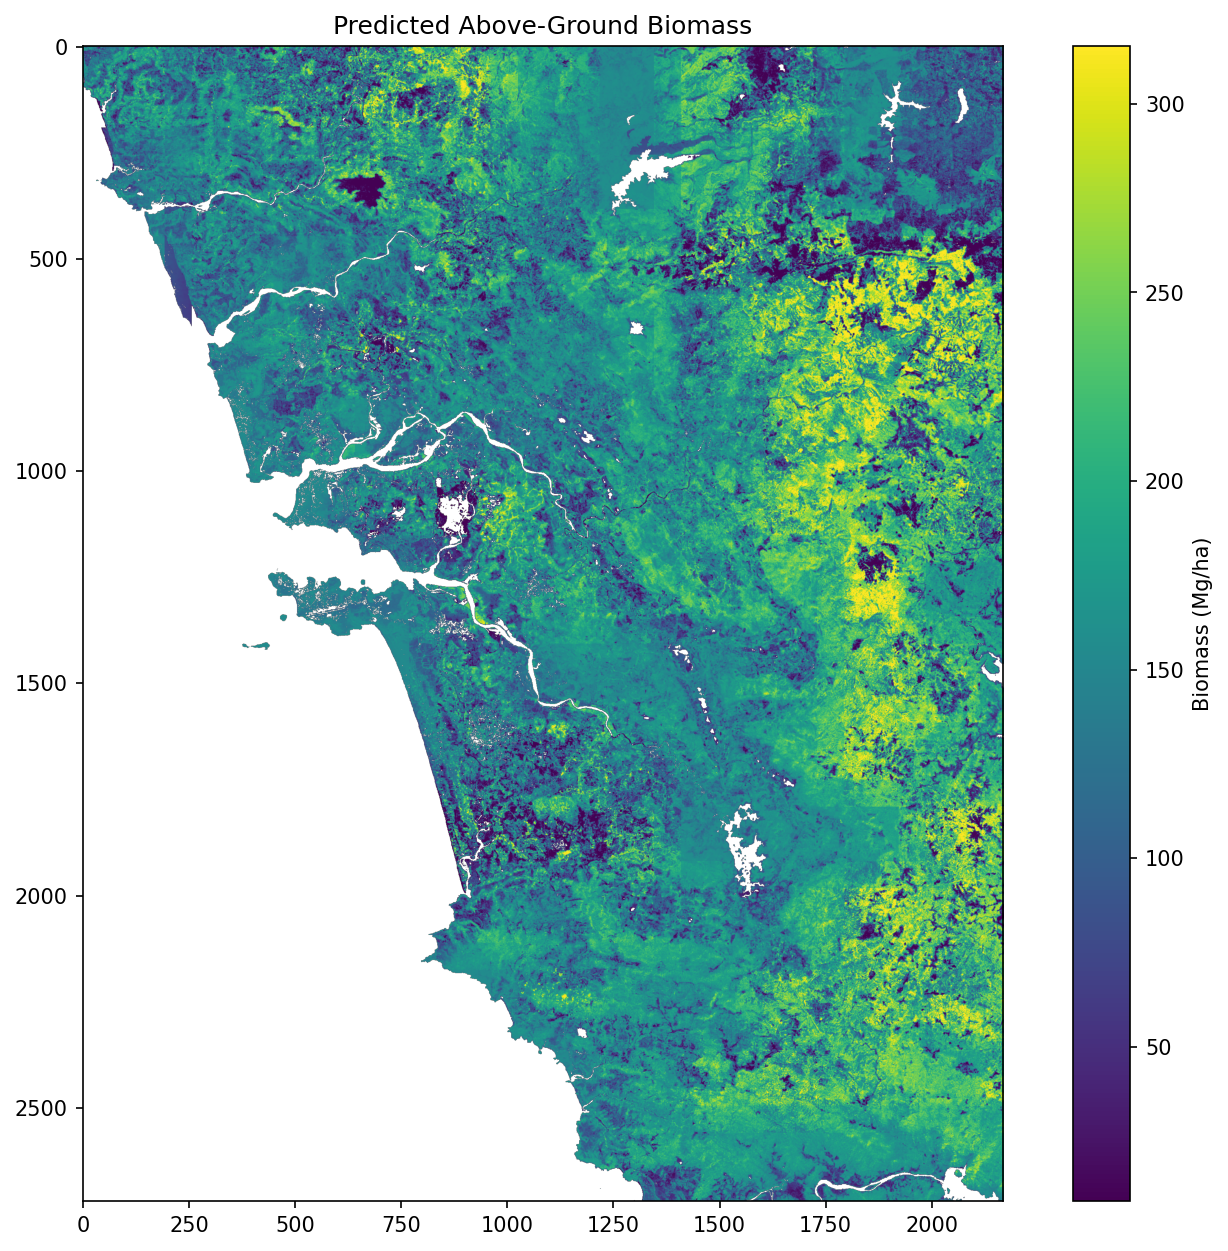


===== Prediction Raster Information =====
Size: 2168x2721
CRS: EPSG:4326
Transform: | 0.00, 0.00, 73.64|
| 0.00,-0.00, 15.85|
| 0.00, 0.00, 1.00|


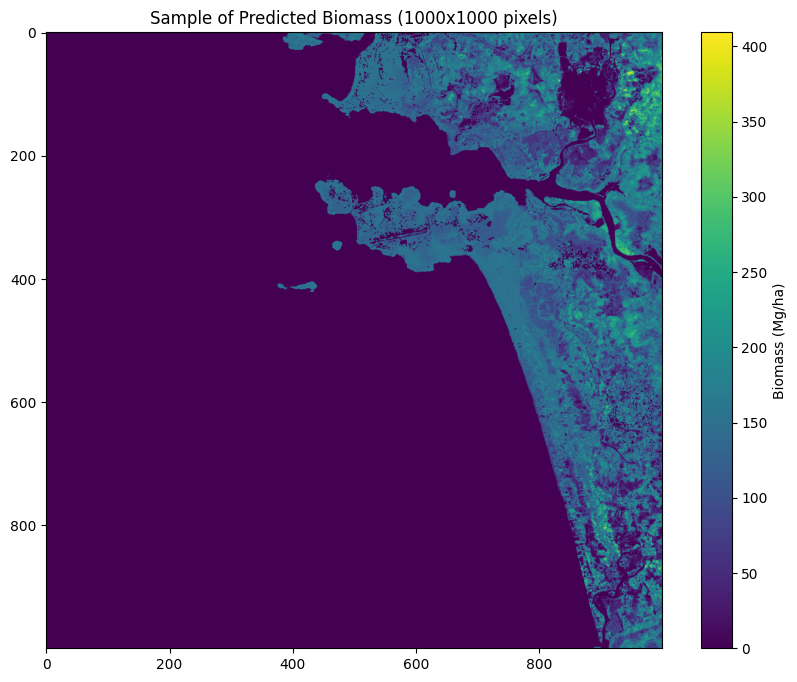

In [12]:
def display_existing_results(output_dir):
    """Load and display existing results"""
    # Check if output files exist
    output_tif = os.path.join(output_dir, "biomass_prediction.tif")
    stats_file = os.path.join(output_dir, "statistics.txt")
    viz_file = os.path.join(output_dir, "biomass_visualization.png")
    
    if not os.path.exists(output_tif):
        print(f"No prediction file found at {output_tif}")
        return
    
    # Load and display statistics
    if os.path.exists(stats_file):
        print("\n===== Biomass Statistics =====")
        with open(stats_file, 'r') as f:
            print(f.read())
    
    # Display visualization
    if os.path.exists(viz_file):
        try:
            from IPython.display import Image, display
            print("\n===== Biomass Visualization =====")
            display(Image(filename=viz_file))
        except Exception as e:
            print(f"Error displaying visualization: {e}")
    
    # Load and display a sample of the prediction raster
    try:
        with rasterio.open(output_tif) as src:
            print("\n===== Prediction Raster Information =====")
            print(f"Size: {src.width}x{src.height}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            
            # Load a small sample for viewing
            sample_size = min(1000, src.width, src.height)
            sample = src.read(1, window=Window(0, 1000, sample_size, sample_size))
            
            # Display sample
            plt.figure(figsize=(10, 8))
            plt.imshow(sample, cmap='viridis')
            plt.colorbar(label='Biomass (Mg/ha)')
            plt.title(f'Sample of Predicted Biomass ({sample_size}x{sample_size} pixels)')
            plt.show()
    except Exception as e:
        print(f"Error loading prediction raster: {e}")

# Uncomment the following line to display existing results in a specified directory
display_existing_results(config.output_dir)